In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
from osl_dynamics.utils import plotting
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans2
import faiss

from osl_dynamics import run_pipeline, inference, analysis
from osl_dynamics.analysis import spectral
from osl_dynamics.data import Data, task

2023-04-24 14:59:11 INFO faiss.loader: Loading faiss with AVX2 support.
2023-04-24 14:59:12 INFO faiss.loader: Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2023-04-24 14:59:12 INFO faiss.loader: Loading faiss.
2023-04-24 14:59:12 INFO faiss.loader: Successfully loaded faiss.


In [18]:
import torch
data = np.random.randint(1000, size=(43000, 306, 256), dtype=np.int16)
data = torch.IntTensor(data)

In [19]:
data.element_size() * data.nelement() // 3

4491264000

In [2]:
# experiment with LSH
data_dir = os.path.join('/', 'well', 'woolrich', 'projects', 'cichy118_cont', 'preproc_data_osl', 'subj1', 'osl_dynamics100hz.mat')
data = loadmat(data_dir)['X'].T
data = data.astype(np.float32)
val_data = data[:10000]
data = data[10000:]

In [22]:
# put the 306 channels into 6 buckets based on covariance
# in each bucket the channels should have similar covariances

num_buckets = 6
num_samples, num_features = data.shape

# Compute the covariance matrix of the features
cov_matrix = np.cov(data, rowvar=False)

# Apply K-means clustering on the covariance matrix
kmeans = KMeans(n_clusters=num_buckets, random_state=0).fit(cov_matrix)

# Create a dictionary to store the features in each bucket
buckets = {i: [] for i in range(num_buckets)}

# Assign features to the corresponding buckets
for feature_idx, bucket in enumerate(kmeans.labels_):
    buckets[bucket].append(feature_idx)

/well/woolrich/users/yaq921/.conda/envs/job_run/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: >

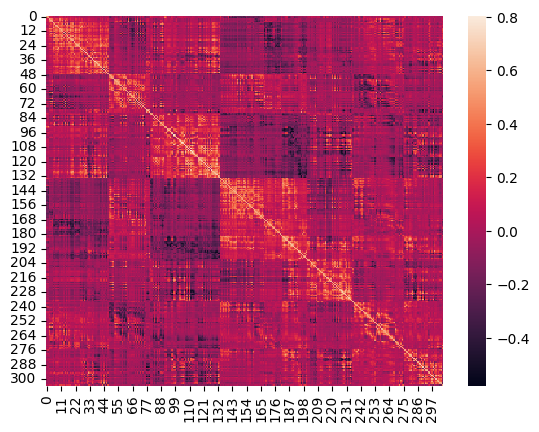

In [23]:
# Compute the covariance matrix in each bucket
bucket_covs = {}
feature_order = []
for bucket, features in buckets.items():
    bucket_covs[bucket] = np.cov(data[:, features], rowvar=False)
    feature_order.extend(features)

cov = np.cov(data[:, feature_order], rowvar=False)
sns.heatmap(cov)

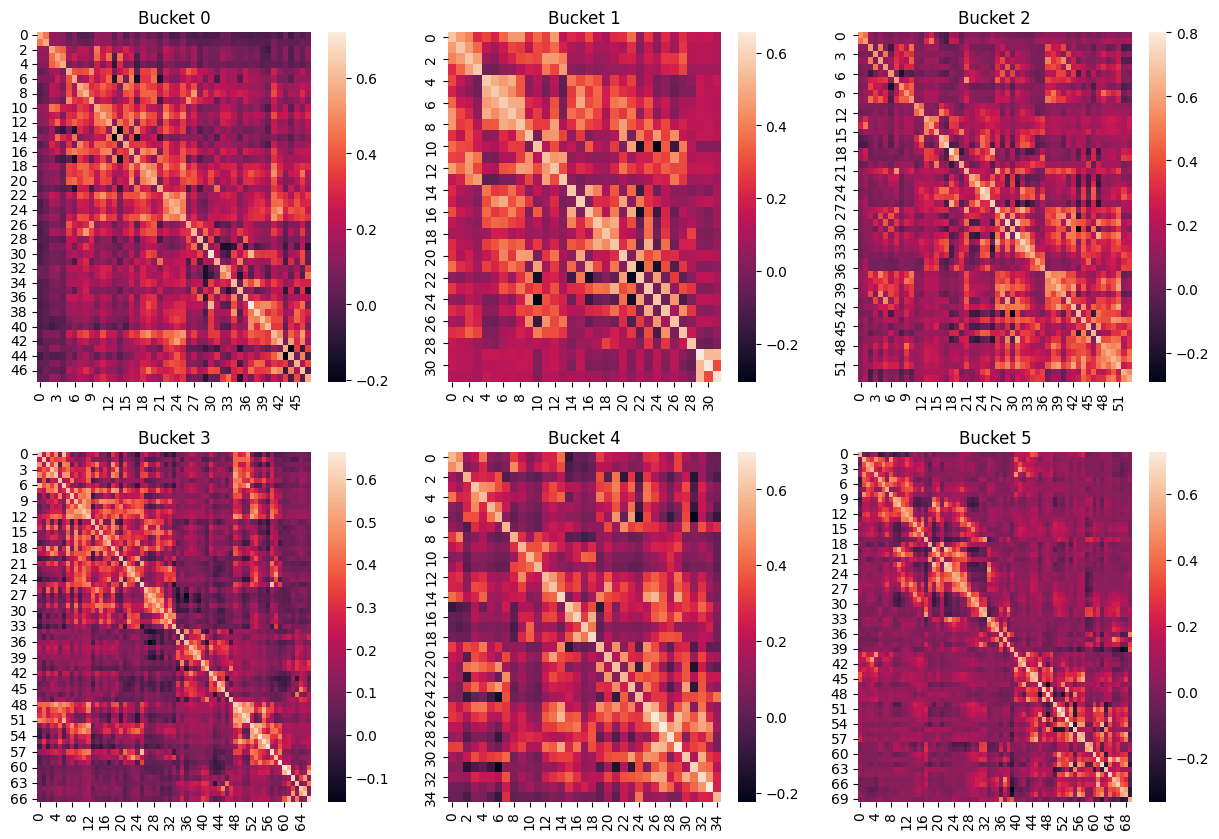

In [13]:
# plot the covariance matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (bucket, cov) in enumerate(bucket_covs.items()):
    ax = axes[i // 3, i % 3]
    sns.heatmap(cov, ax=ax)
    ax.set_title(f'Bucket {bucket}')

In [97]:
# product quantization
# Set parameters for Product Quantization
num_subspaces = 1  # Number of subspaces
num_clusters_per_subspace = 16  # Total quantization bins = num_clusters_per_subspace ** num_subspaces = 100k

# Initialize the Product Quantizer index
quantizer = faiss.ProductQuantizer(306, num_subspaces, num_clusters_per_subspace)
quantizer.train(data)

In [ ]:
# product quantization
# Set parameters for Product Quantization
num_subspaces = 9  # Number of subspaces
num_clusters_per_subspace = 2  # Total quantization bins = num_clusters_per_subspace ** num_subspaces = 100k

# Initialize the Product Quantizer index
quantizer = faiss.ResidualQuantizer(306, num_subspaces, num_clusters_per_subspace)
quantizer.train(data)

In [26]:
num_subspaces = 2  # Number of subspaces
num_clusters_per_subspace = 8  # Total quantization bins = num_clusters_per_subspace ** num_subspaces = 100k

# create a residual quantizer for each bucket of features
residual_quantizers = {}
for bucket, features in buckets.items():
    res_quant = faiss.ResidualQuantizer(len(features), num_subspaces, num_clusters_per_subspace)
    res_quant.train(np.ascontiguousarray(data[:, features]))

    codes = res_quant.compute_codes(val_data[:, features])
    recon = res_quant.decode(codes)

    print(((val_data[:, features] - recon)**2).sum() / (val_data[:, features] ** 2).sum())

KeyboardInterrupt: 

In [114]:
# encode 
codes = quantizer.compute_codes(val_data)

# decode
recon = quantizer.decode(codes)

((val_data - recon)**2).sum() / (val_data ** 2).sum()

0.3844748

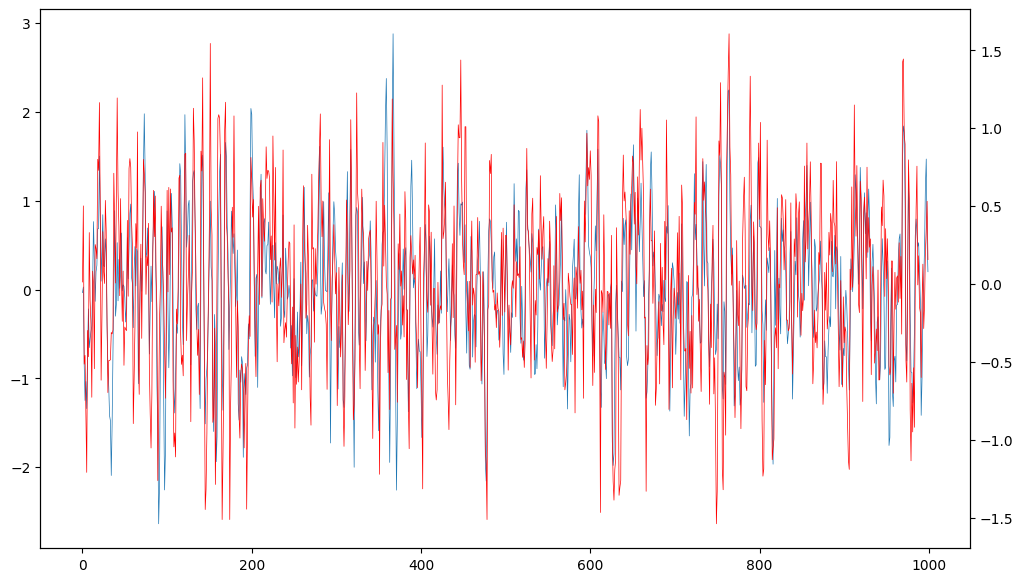

In [116]:
# compare reconstruction
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(val_data[:, 22], linewidth=0.5)

ax2 = ax.twinx()
ax2.plot(recon[:, 22], linewidth=0.5, color='r')

In [108]:
# count unique elements in each column of codes
for i in range(codes.shape[1]):
    print(np.unique(codes[:, i]).shape)

(256,)
(256,)


In [ ]:
# hierarchical clustering
class HierarchicalKMeans:
    def __init__(self, levels, k=2):
        self.levels = levels
        self.k = k
        self.models = []

    def fit(self, X, current_level=0):
        if current_level == self.levels:
            return

        kmeans = KMeans(n_clusters=self.k, random_state=0)
        kmeans.fit(X)
        self.models.append(kmeans)

        for cluster_id in range(self.k):
            X_cluster = X[kmeans.labels_ == cluster_id]
            self.fit(X_cluster, current_level + 1)

    def predict(self, X):
        return self.predict_recursive(X, current_level=0)

    def predict_recursive(self, X, current_level):
        if current_level == self.levels - 1:
            return self.models[current_level].predict(X)

        cluster_ids = self.models[current_level].predict(X)
        quantized = np.zeros(X.shape[0], dtype=int)

        for cluster_id in range(self.k):
            X_cluster = X[cluster_ids == cluster_id]
            if X_cluster.shape[0] == 0:
                continue

            quantized[cluster_ids == cluster_id] = cluster_id * self.k + self.predict_recursive(X_cluster, current_level + 1)

        return quantized

num_levels = 4
num_clusters_per_level = 8

hierarchical_kmeans = HierarchicalKMeans(levels=num_levels, k=num_clusters_per_level)
hierarchical_kmeans.fit(data)
quantized = hierarchical_kmeans.predict(data)

In [88]:
quantized[10000:10200]

array([4, 2, 2, 4, 3, 3, 4, 2, 2, 2, 0, 2, 4, 4, 4, 4, 4, 4, 2, 2, 4, 2,
       2, 4, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 4, 0, 2, 3, 1, 1, 1, 3, 3, 1,
       1, 1, 3, 3, 1, 1, 5, 5, 3, 2, 2, 4, 2, 4, 5, 1, 1, 2, 2, 2, 2, 4,
       3, 3, 2, 2, 2, 2, 4, 4, 2, 2, 0, 4, 4, 4, 2, 0, 0, 4, 4, 4, 2, 3,
       3, 3, 1, 0, 4, 2, 2, 2, 4, 3, 2, 0, 0, 2, 2, 5, 1, 0, 1, 2, 4, 4,
       4, 3, 1, 1, 2, 2, 0, 2, 4, 5, 1, 1, 1, 2, 2, 2, 5, 5, 2, 2, 2, 2,
       4, 4, 4, 2, 0, 2, 2, 0, 4, 2, 4, 2, 0, 1, 3, 5, 2, 0, 3, 3, 3, 2,
       2, 3, 5, 3, 3, 2, 0, 1, 1, 0, 3, 2, 4, 4, 2, 3, 2, 2, 2, 2, 2, 4,
       4, 2, 2, 2, 5, 3, 5, 3, 3, 3, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 4,
       4, 2])

In [77]:
num_samples = 100
num_buckets = 1000000
num_features = 306
original_data = data[:num_samples]
random_rotations = np.random.randn(num_features, num_buckets)
rotated_vectors = np.dot(original_data, random_rotations)
rotated_vectors = np.hstack([rotated_vectors, -rotated_vectors])
buckets = np.argmax(rotated_vectors, axis=-1)

In [78]:
# Create unit vectors for each bucket
unit_vectors = np.zeros((len(buckets), 2 * num_buckets))
unit_vectors[np.arange(len(buckets)), buckets] = 1

# Separate positive and negative unit_vectors
unit_vectors_positive = unit_vectors[:, :num_buckets]
unit_vectors_negative = unit_vectors[:, num_buckets:]

# Calculate the selected unit vectors based on the bucket indices
selected_unit_vectors = np.where(buckets[:, None] < num_buckets, unit_vectors_positive, -unit_vectors_negative)

# Invert the rotation transformation
random_rotations_inv = np.linalg.pinv(random_rotations)
reconstructed_data = np.dot(selected_unit_vectors, random_rotations_inv)

In [67]:
reconstructed_data.shape

(100, 306)

In [59]:
# get back the original data based on the buckets
# has to have shape (100, 306)
# Step 1: Identify the chosen rotated vector for each feature vector
positive_indices = buckets < num_buckets
rotated_vectors_positive = rotated_vectors[:, :num_buckets]
rotated_vectors_negative = rotated_vectors[:, num_buckets:]

selected_rotated_vectors = np.where(positive_indices[:, None], rotated_vectors_positive, rotated_vectors_negative)

# Step 2: Invert the rotation transformation
random_rotations_inv = np.linalg.pinv(random_rotations)
reconstructed_data = np.dot(selected_rotated_vectors, random_rotations_inv)

signs = np.sign(np.sum(original_data * reconstructed_data, axis=-1))
reconstructed_data *= signs[:, None]

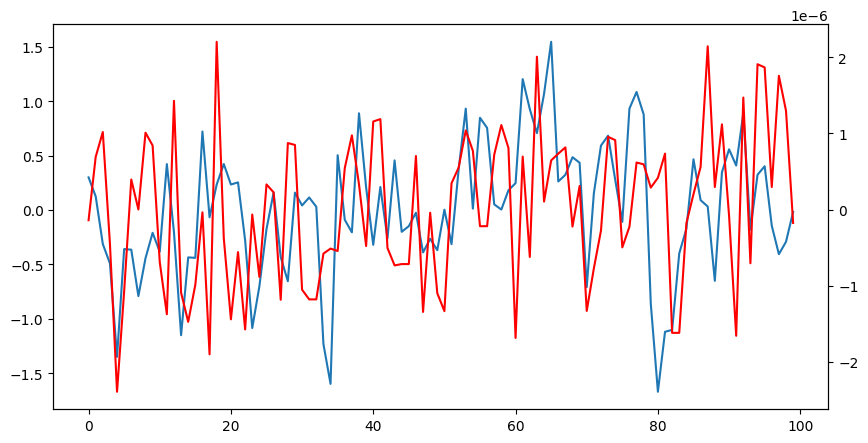

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(original_data[:, 10])

# new axis
ax2 = ax.twinx()
ax2.plot(reconstructed_data[:, 10], color='red')

In [22]:
buckets

array([149503,  44813,  44813, 116734, 138885,  56956, 188252, 178650,
       199433,  44064, 185301,  13908, 134602, 196455,  39215,  19393,
        57443,  76171, 146015,  99433,  99433, 116414, 109266, 133420,
        49430,  23021, 148831, 100938, 182665, 165415, 189961, 153412,
       153412, 194611,  99182,   9323,   9323,  24355, 118257,  13908,
       173470,  31809,  28900, 192203, 171692,  36125,  49894, 122548,
       114485,  97212,   3418, 146282,    252, 153067, 158746,  24281,
       171462,  83249,  95156, 112491,   5394, 163065,  61775,  42921,
        23059,  23515,  12771, 134511, 134511, 135163, 199433, 196276,
        25717,  71108, 186824, 187433, 177794, 177794, 178692,   7949,
        27869,  59566,   3582, 105221,  46692, 143727, 107552,  77797,
       171462, 107594, 183932, 119342, 155141,   3588,  15898, 100252,
        10954, 109776,  14383,  43727])

In [4]:
def mulaw_inv(x, mu=255):
    '''
    Inverse mu-law companding.
    '''
    shape = x.shape

    x = x.reshape(-1)
    x = (x - 0.5) / mu * 2 - 1
    x = np.sign(x)*((1+mu)**np.abs(x)-1)/mu

    x = x.reshape(shape)
    return x

def encode(xtn):
    '''
    Encode data using mu-law companding.
    '''
    xtn = np.clip(xtn, -4, 4)

    maxabs = MaxAbsScaler()

    xtn = maxabs.fit_transform(xtn)
    return mulaw(xtn)

def mulaw(x):
    '''
    Apply mu-law companding to input data.
    '''
    mu = 255
    shape = x.shape

    x = x.reshape(-1)
    x = np.sign(x)*np.log(1+mu*np.abs(x))/np.log(1+mu)

    digitized = ((x + 1) / 2 * mu+0.5).astype(np.int32)
    x = 2 * ((digitized).astype(np.float32) / mu) - 1

    x = x.reshape(shape)
    digitized = digitized.reshape(shape)

    return digitized

In [81]:
# load data
data_dir = os.path.join('/', 'well', 'woolrich', 'projects', 'cichy118_cont', 'preproc_data_osl', 'subj1', 'osl_dynamics100hz.mat')
data_dir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'cont_quantized',
'gpt2_50hz100hz', 'separate_output_proj', 'saved_kv', 'generated_datarecursivetop-p1.mat')

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_saved_kv_100hz')
os.makedirs(savedir, exist_ok=True)

# convert .mat to .npy
orig_data = loadmat(data_dir)['X'].T
# apply robustscaler
if savedir.endswith('_100hz'):
    data = mulaw_inv(orig_data)
else:
    data = encode(orig_data)
    data = mulaw_inv(data)

data = RobustScaler().fit_transform(data)
print(data.shape)

np.save(os.path.join(savedir, 'subject01.npy'), data)

(360256, 306)


In [9]:
def power_spectra(path):
    alp = pickle.load(open(os.path.join(path, 'inf_params', 'alp.pkl'), 'rb'))
    f = np.load(os.path.join(path, 'spectra', 'f.npy'))
    psd = np.load(os.path.join(path, 'spectra', 'psd.npy'))
    
    # Average over subjects and channels
    psd_mean = np.mean(psd, axis=(1))

    # Plot
    n_states = psd_mean.shape[0]
    plotting.plot_line(
        [f] * n_states,
        psd_mean,
        labels=[f"State {i}" for i in range(1, n_states + 1)],
        x_label="Frequency (Hz)",
        y_label="PSD (a.u.)",
        x_range=[f[0], f[-1]],
    )

def plot(path):
    # Load the training history
    history = pickle.load(open(os.path.join(path, 'trained_model', 'history.pkl'), "rb"))

    print("Free energy:", history["free_energy"])

    alp = pickle.load(open(os.path.join(path, 'inf_params', 'alp.pkl'), 'rb'))
    stc = inference.modes.argmax_time_courses(alp)

    print(alp.shape)

    fo = analysis.modes.fractional_occupancies(stc)
    lt = analysis.modes.mean_lifetimes(stc, sampling_frequency=100)
    intv = analysis.modes.mean_intervals(stc, sampling_frequency=100)
    sr = analysis.modes.switching_rates(stc, sampling_frequency=100)

    plotting.plot_alpha(alp[alp.shape[0]//2:], n_samples=2000)

    # Create a pandas dataframe containing the summary stats
    # This will be helpful for plotting
    # Each line in the dataframe is a subject
    '''
    ss_dict = {
        "Fractional Occupancy": [],
        "Mean Lifetime (s)": [],
        "Mean Interval (s)": [],
        "Switching Rate (Hz)": [],
        "State": [],
    }
    n_states = fo.shape[0]
    for state in range(n_states):
        ss_dict["Fractional Occupancy"].append(fo[state])
        ss_dict["Mean Lifetime (s)"].append(lt[state])
        ss_dict["Mean Interval (s)"].append(intv[state])
        ss_dict["Switching Rate (Hz)"].append(sr[state])
        ss_dict["State"].append(state + 1)
    ss_df = pd.DataFrame(ss_dict)

    # Plot
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 4))
    sns.violinplot(data=ss_df, x="State", y="Fractional Occupancy", ax=ax[0])
    sns.violinplot(data=ss_df, x="State", y="Mean Lifetime (s)", ax=ax[1])
    sns.violinplot(data=ss_df, x="State", y="Mean Interval (s)", ax=ax[2])
    sns.violinplot(data=ss_df, x="State", y="Switching Rate (Hz)", ax=ax[3])
    '''

    ss_dict = {
        "Fractional Occupancy": [],
        "Mean Lifetime (s)": [],
        "Mean Interval (s)": [],
        "Switching Rate (Hz)": [],
    }
    n_states = fo.shape[0]
    for state in range(n_states):
        ss_dict["Fractional Occupancy"].append(fo[state])
        ss_dict["Mean Lifetime (s)"].append(lt[state])
        ss_dict["Mean Interval (s)"].append(intv[state])
        ss_dict["Switching Rate (Hz)"].append(sr[state])
    ss_df = pd.DataFrame(ss_dict)

    # Plot
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 4))
    sns.violinplot(data=ss_df, y="Fractional Occupancy", ax=ax[0], color='red', cut=0)

    # set y limits
    ax[0].set_ylim(0, 0.2)
    sns.violinplot(data=ss_df, y="Mean Lifetime (s)", ax=ax[1], color='green', cut=0)

    # set y limits
    ax[1].set_ylim(0.1, 0.45)
    sns.violinplot(data=ss_df, y="Mean Interval (s)", ax=ax[2], color='blue', cut=0)

    # set y limits
    ax[2].set_ylim(1, 5)
    sns.violinplot(data=ss_df, y="Switching Rate (Hz)", ax=ax[3], color='purple', cut=0)

    ax[3].set_ylim(0.2, 0.9)

    return alp, stc

def evoked_comparison(epochs_list, names=['data', 'gpt2'], chn_ids=[0]):
    values = []
    times = []
    channel = []
    trial = []
    models = []
    for epochs, name in zip(epochs_list, names):
        epochs = epochs[:, :, chn_ids]
        trials, time, chn = epochs.shape
        # create seaborn plot that shows the average evoked response for each channel
        # in epochs (trials, time, channels). use shading to show the standard deviation
        # use the following code to create the dataframe
        values.append(epochs.reshape(-1))

        # add time, channel, and trial columns
        times.append(np.tile(np.repeat(np.arange(time), chn), trials))
        channel.append(np.tile(np.arange(chn), time * trials))
        trial.append(np.repeat(np.arange(trials), time * chn))

        models.extend([name] * len(values[-1]))


    # create dataframe
    df = pd.DataFrame({
        'value': np.concatenate(values),
        'time': np.concatenate(times),
        'channel': np.concatenate(channel),
        'trial': np.concatenate(trial),
        'model': models,
    })

    # plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.lineplot(data=df, x='time', y='value', hue='channel', ax=ax, style='model')

def evoked_analysis(base, data=True, ret_epochs=False):
    alp = pickle.load(open(os.path.join(base, 'inf_params', 'alp.pkl'), 'rb'))
    stc = inference.modes.argmax_time_courses(alp)

    # load event timings
    if data:
        path = os.path.join(base, 'event_times.npy')
        event_times = np.load(path)
        event_times = [(int(ev[0]/10) - 155520 - 7, ev[2]) for ev in event_times]
        event_times = [np.array(ev[0]) for ev in event_times if ev[0] > 0]
        event_times = np.array(event_times)

    else:
        path = os.path.join(base, 'generate_cond.npy')
        event_times = np.load(path)
        event_times = event_times[1:] - event_times[:-1]

        # get the indices where event_times is greater than 0
        event_times = np.where(event_times > 0)[0] - 6

    # load data
    data = np.load(os.path.join(base, 'subject01.npy'))

    # epoch data
    epochs = task.epoch(data, event_times+7, pre=10, post=100)

    # remove mean from each epoch by subtracting the mean of the first 10 samples
    epochs = epochs - epochs[:, :10, :].mean(axis=1, keepdims=True)
    epochs = epochs[:, 10:, :]
    if ret_epochs:
        return epochs

    event_times = event_times[event_times<stc.shape[0] - 100]

    stc_epochs = task.epoch(stc, event_times, pre=10, post=100)
    avg_stc_epoch = np.mean(stc_epochs, axis=0)

    # Calculate the baseline
    pre = 10  # number of samples before the event
    n_states = avg_stc_epoch.shape[1]
    t = (np.arange(avg_stc_epoch.shape[0]) - pre) / 100
    base_corr = np.nanmean(avg_stc_epoch[:pre], axis=0, keepdims=True)

    # Remove it from the epoched state time courses
    corr_avg_stc_epoch = avg_stc_epoch - base_corr

    # Plot the visual task
    fig, ax = plotting.plot_line([t] * n_states,
                                 corr_avg_stc_epoch.T,
                                 labels=[f"State {i}" for i in range(1, n_states + 1)],
                                 x_range=[-0.1, 1],
                                 x_label="Time (s)",
                                 y_label="Average State Activation",
    )
    ax.axvline(color="r", linestyle="--")

Free energy: 218489.94190644237
(362000, 12)


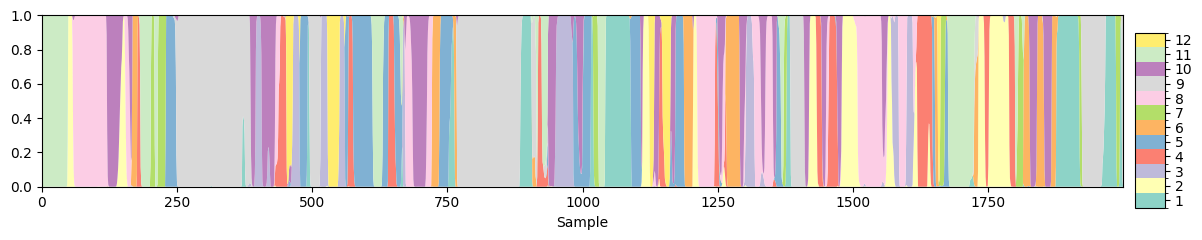

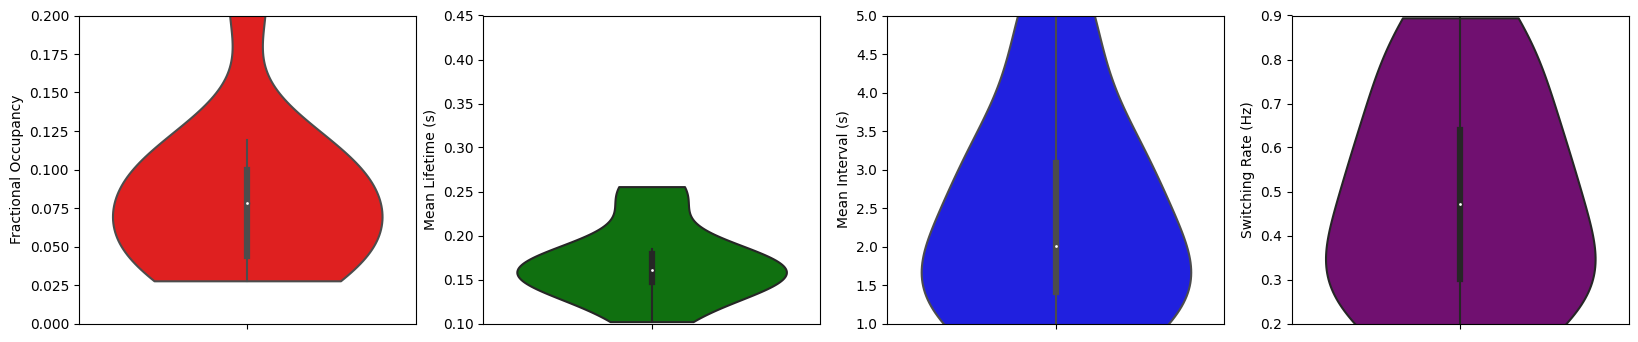

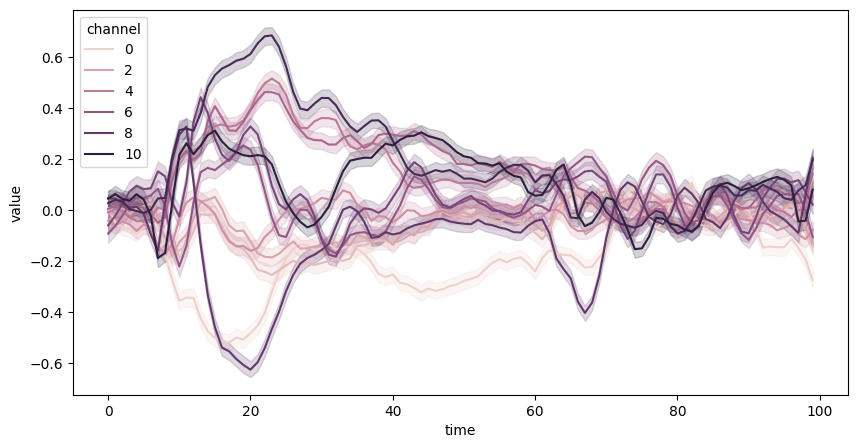

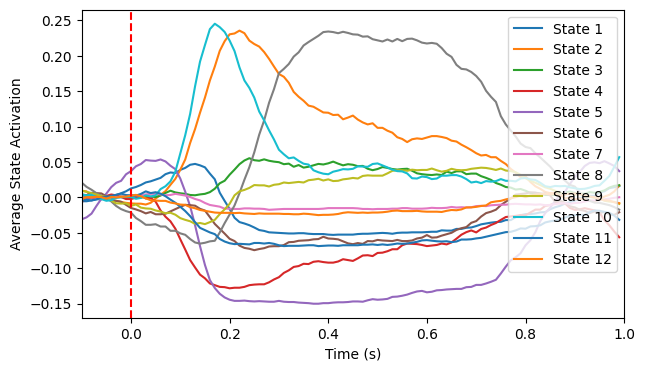

In [28]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', '100hz')
alpha, stc = plot(savedir)
power_spectra(savedir)
df = evoked_analysis(savedir)

Free energy: 223123.76715213407
(358000, 12)


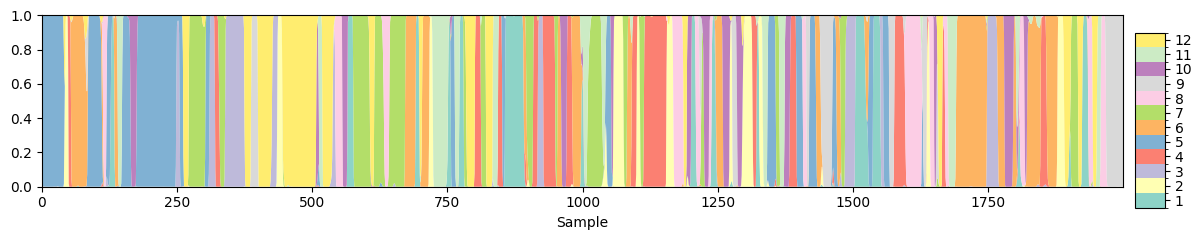

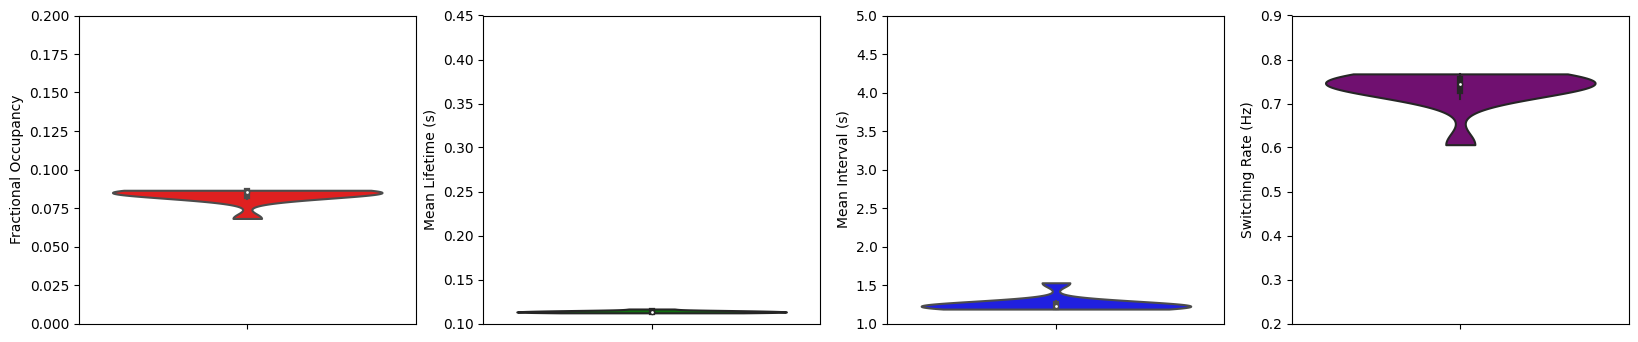

In [51]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'AR255_100hz')
alpha, stc = plot(savedir)
power_spectra(savedir)
#evoked_analysis(savedir)

Free energy: 222756.2243340329
(360000, 12)


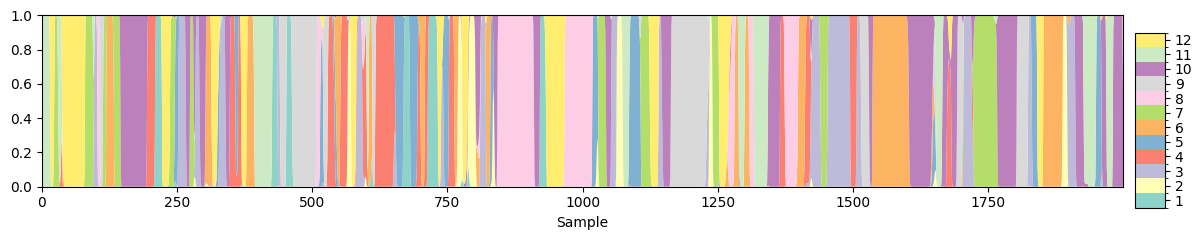

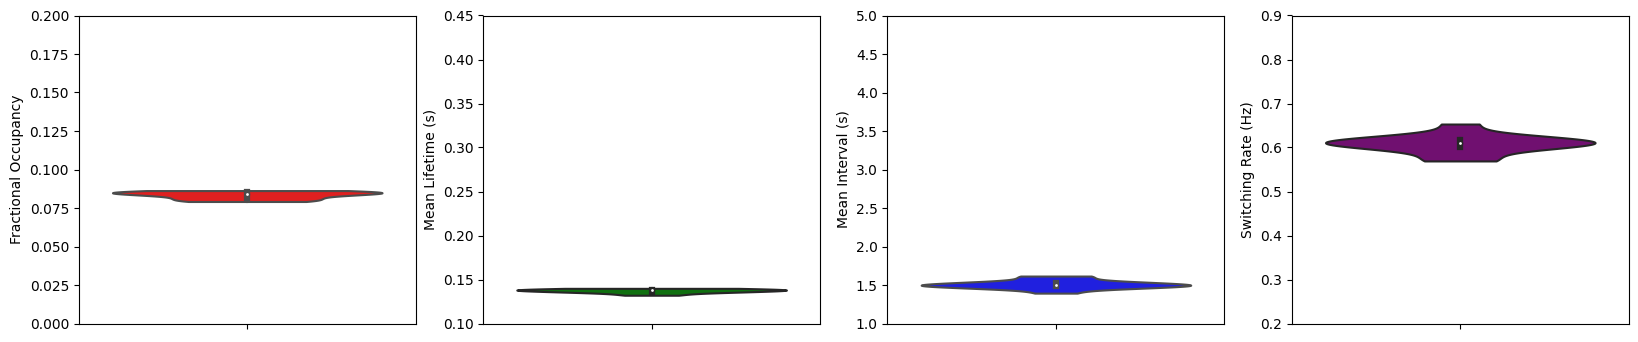

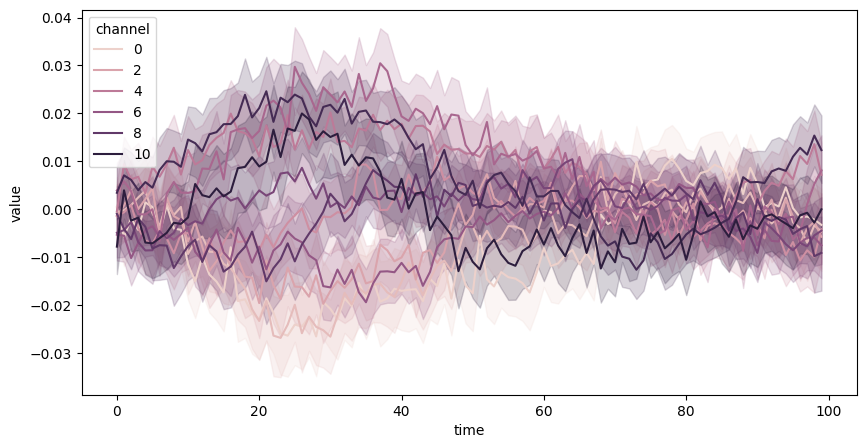

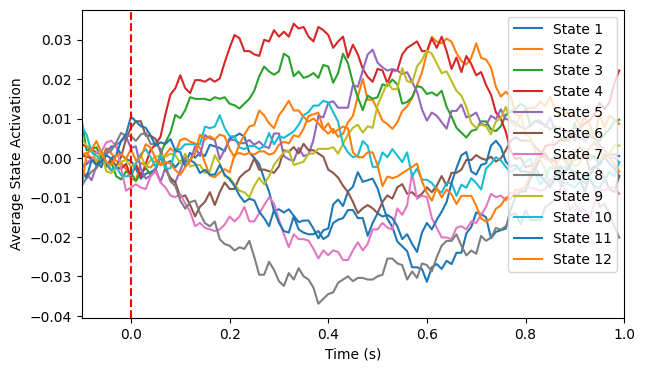

In [30]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'wavenet_100hz')
alpha, stc = plot(savedir)
power_spectra(savedir)
evoked_analysis(savedir, data=False)

Free energy: 209412.01287430245
(360000, 12)


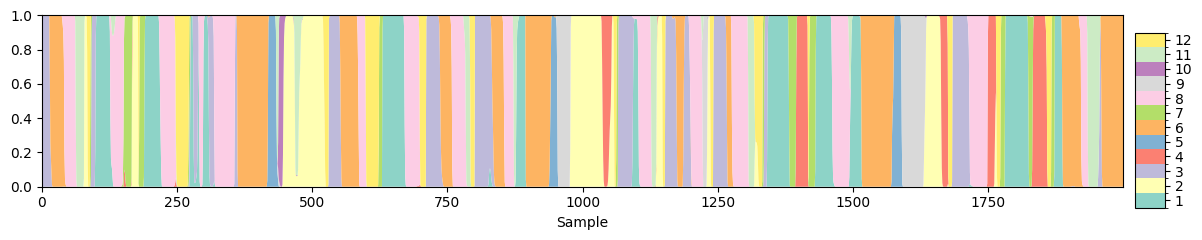

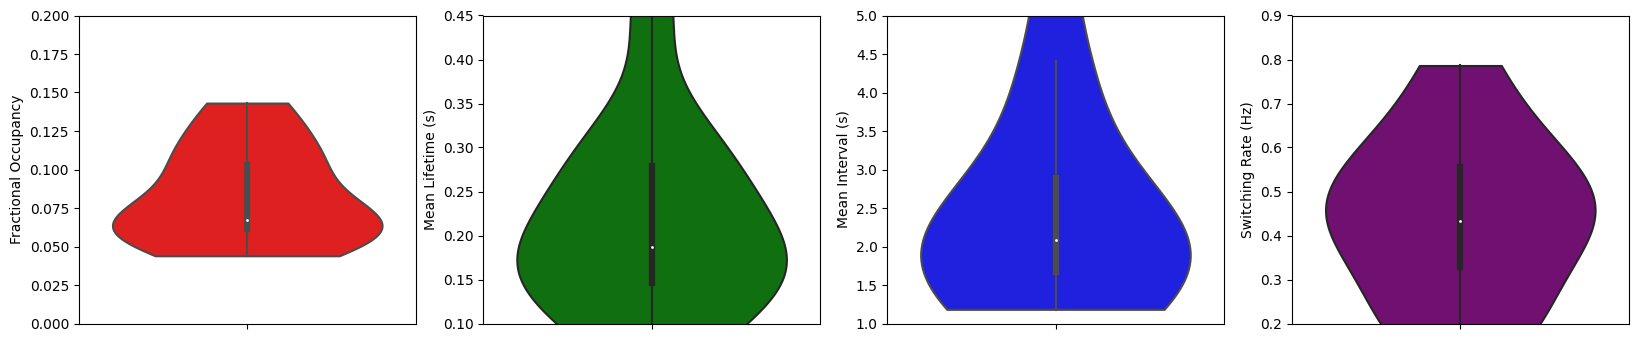

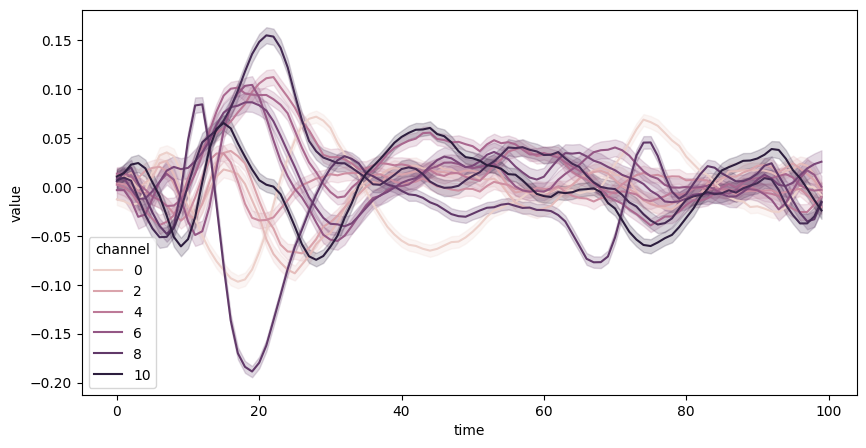

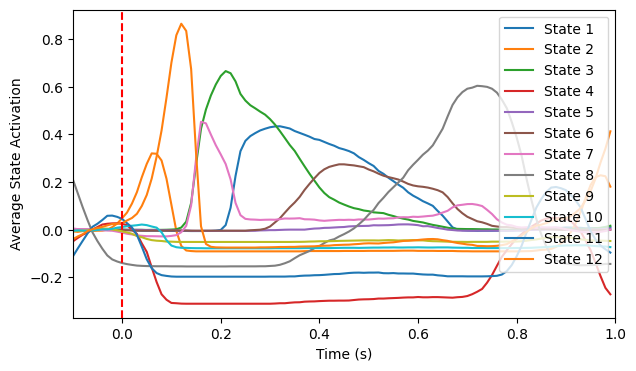

In [29]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_100hz')
alpha, stc = plot(savedir)
power_spectra(savedir)
evoked_analysis(savedir, data=False)

Free energy: 200326.4228046364
(360000, 12)


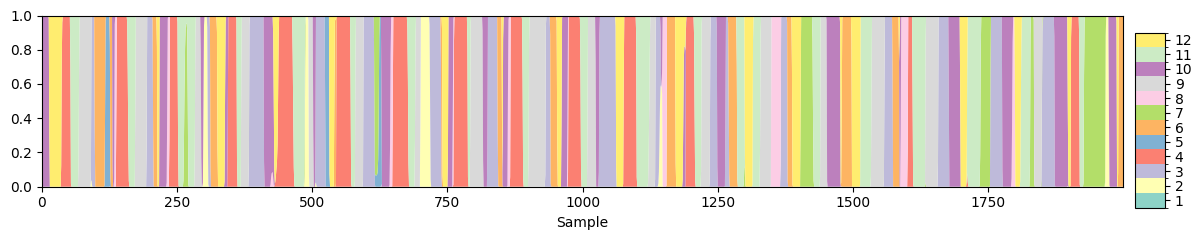

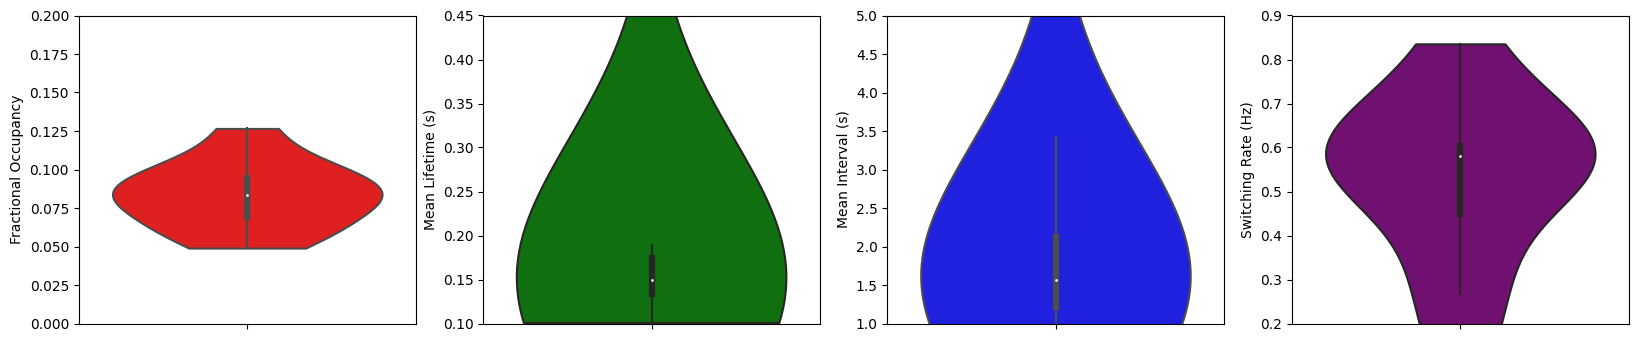

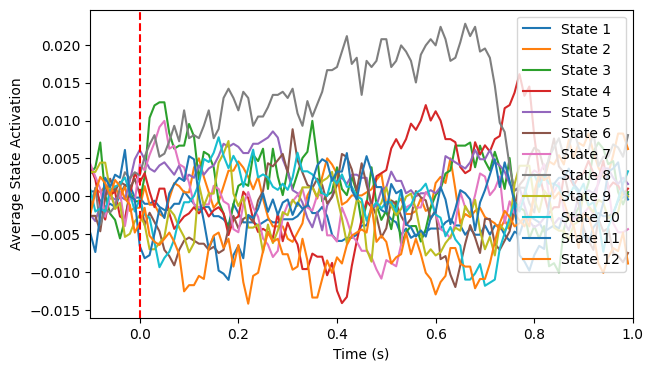

In [16]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_concat_output_100hz')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)

Free energy: 194896.9972712636
(360000, 12)


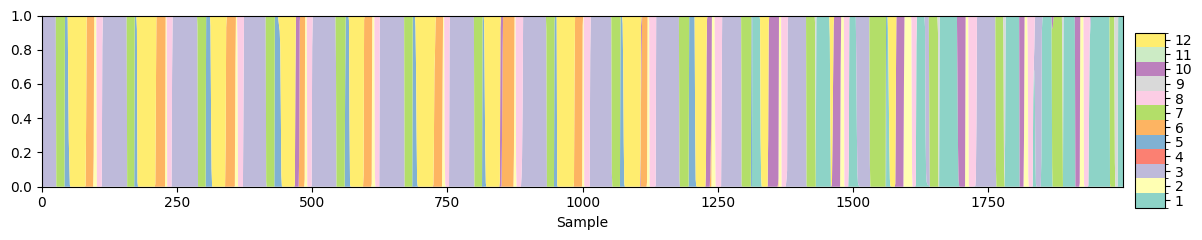

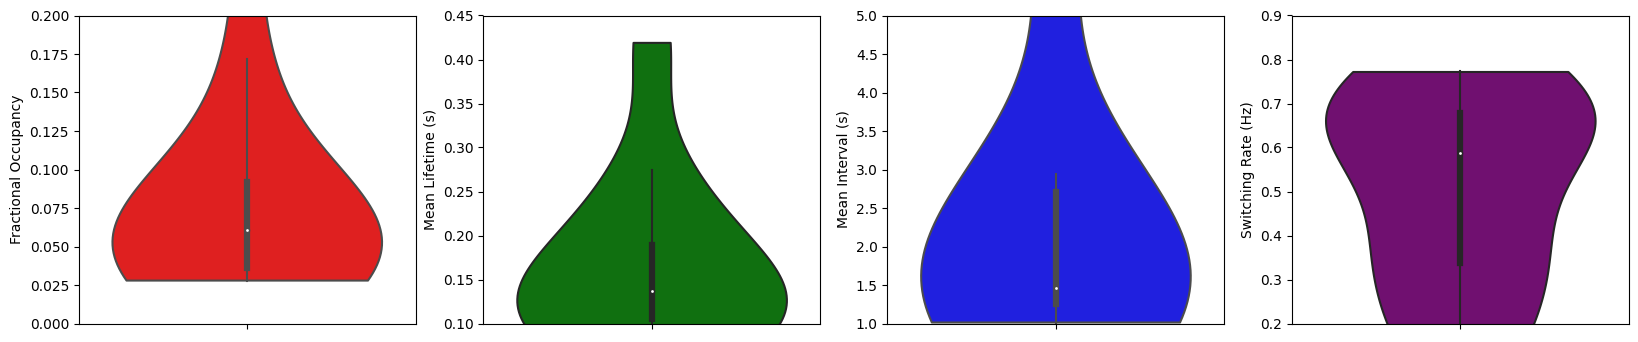

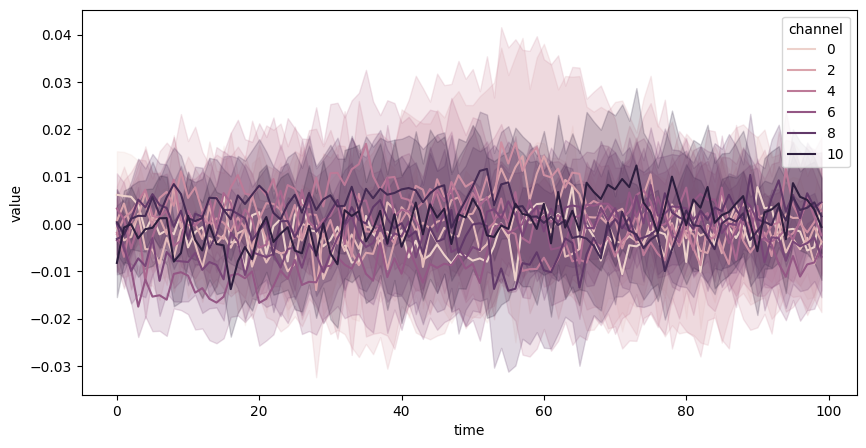

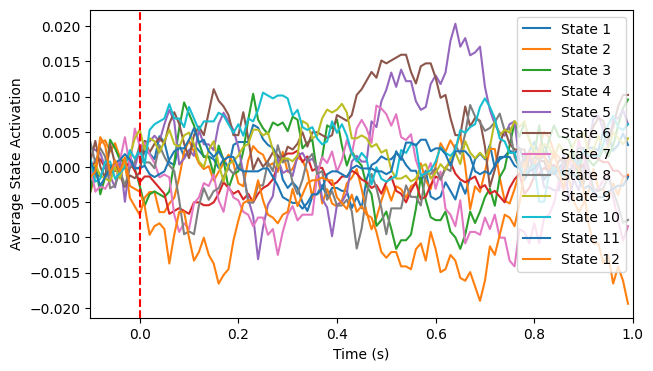

In [34]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2chmixsmall_100hz')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)

Free energy: 201716.51365076296
(360000, 12)


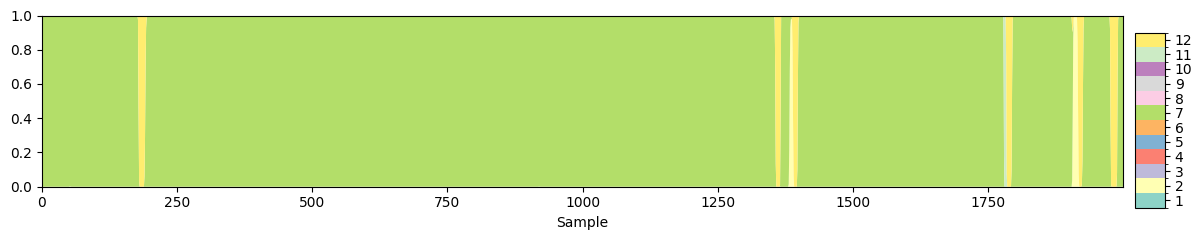

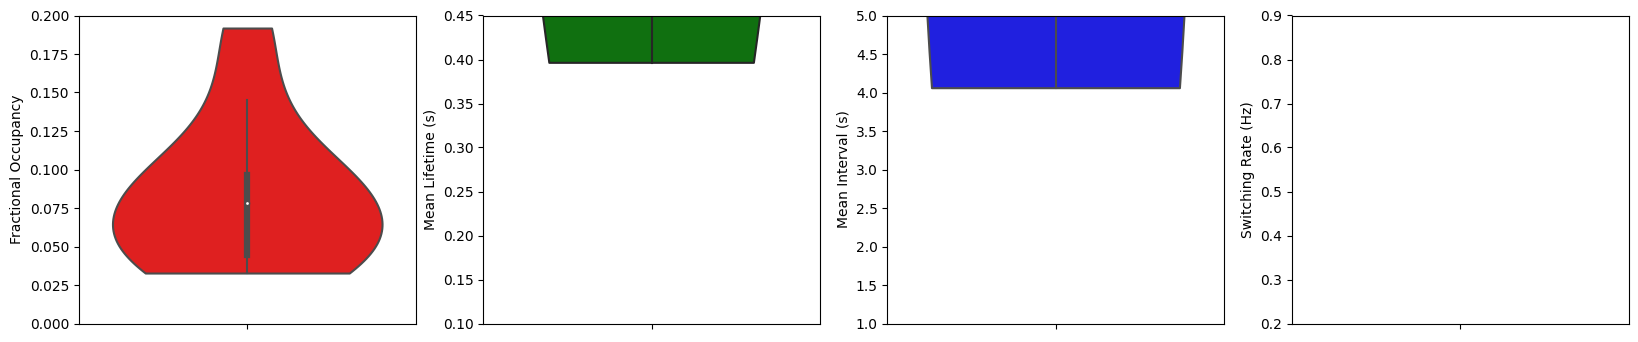

In [10]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_separate_heads_100hz')
alpha, stc = plot(savedir)
#evoked_analysis(savedir, data=False)

Free energy: 215191.3798147263
(360000, 12)


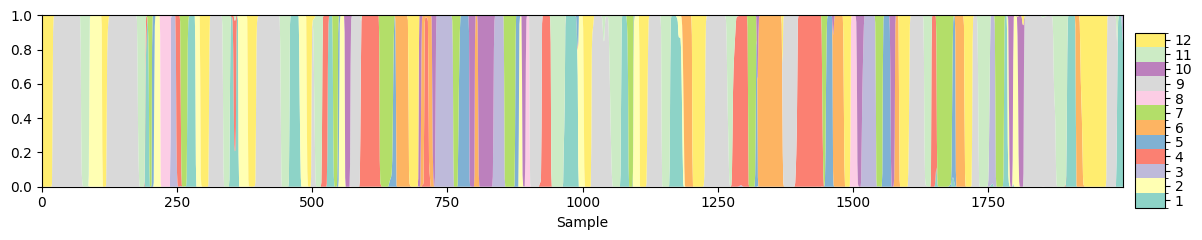

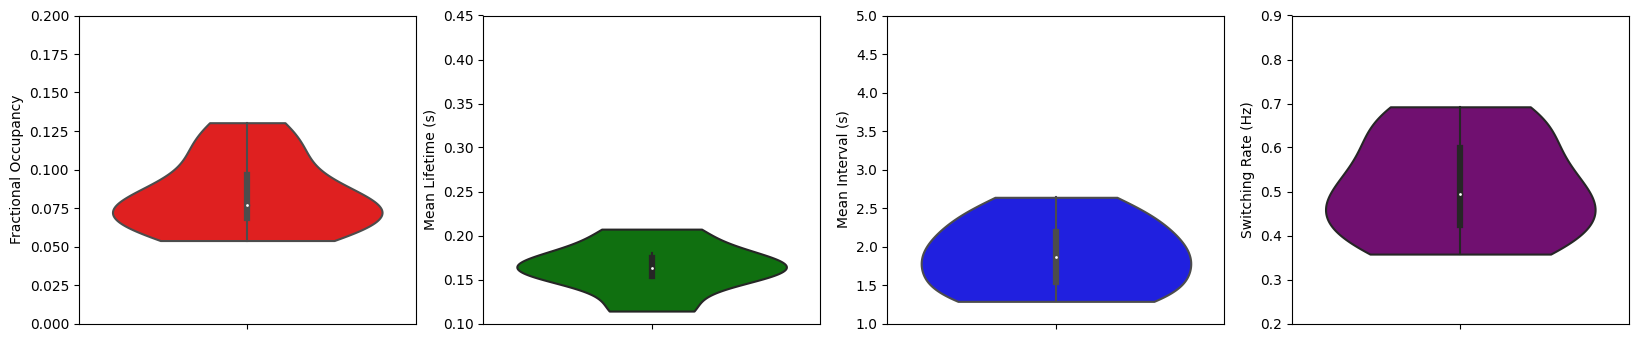

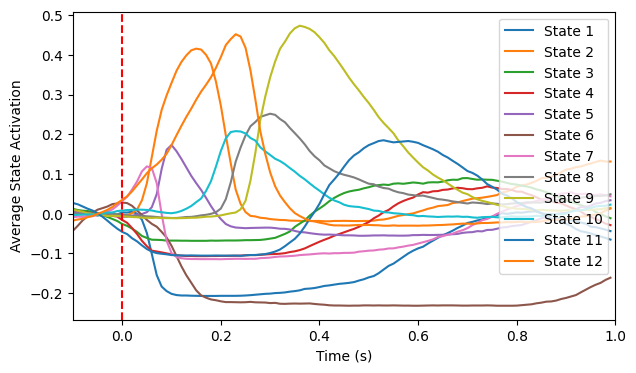

In [11]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_random_condgen_100hz')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)

In [13]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_100hz')
epochs_gpt = evoked_analysis(savedir, data=False, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', '100hz')
epochs_data = evoked_analysis(savedir, data=True, ret_epochs=True)

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_random_condgen_100hz')
epochs_gpt_random = evoked_analysis(savedir, data=False, ret_epochs=True)

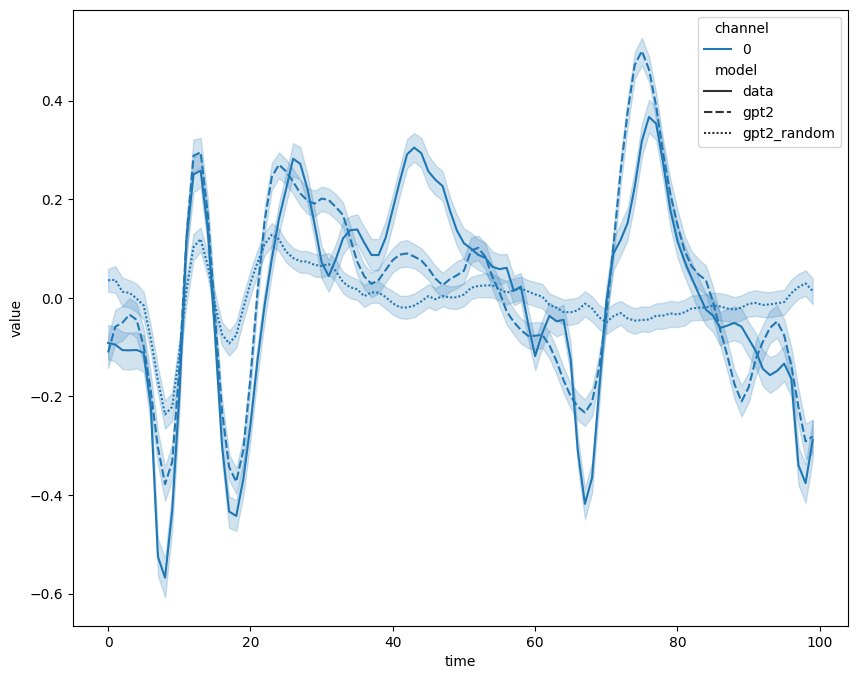

In [15]:
evoked_comparison([epochs_data, epochs_gpt, epochs_gpt_random], chn_ids=[265], names=['data', 'gpt2', 'gpt2_random'])

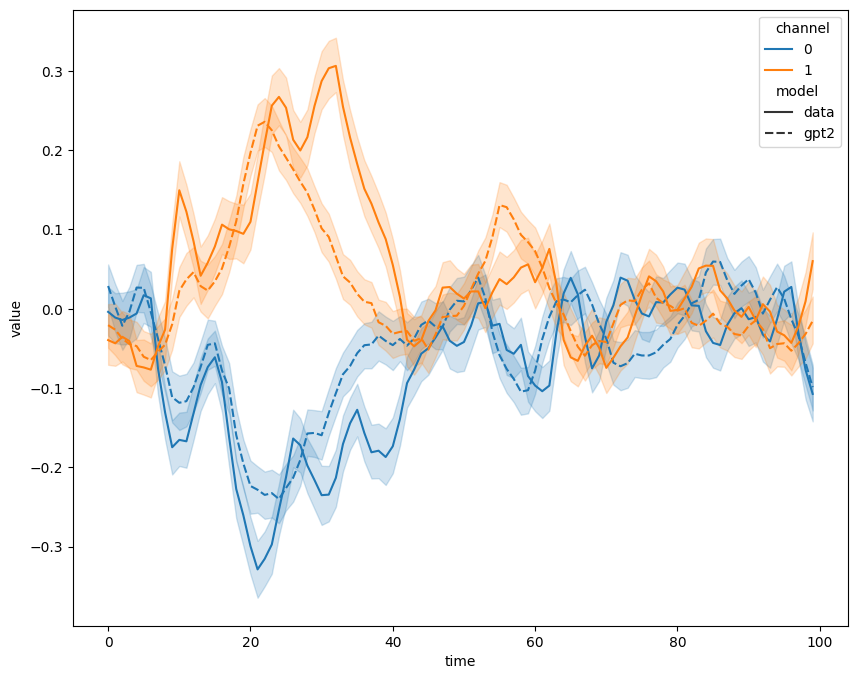

In [25]:
evoked_comparison([epochs_data, epochs_gpt], chn_ids=[76, 77])

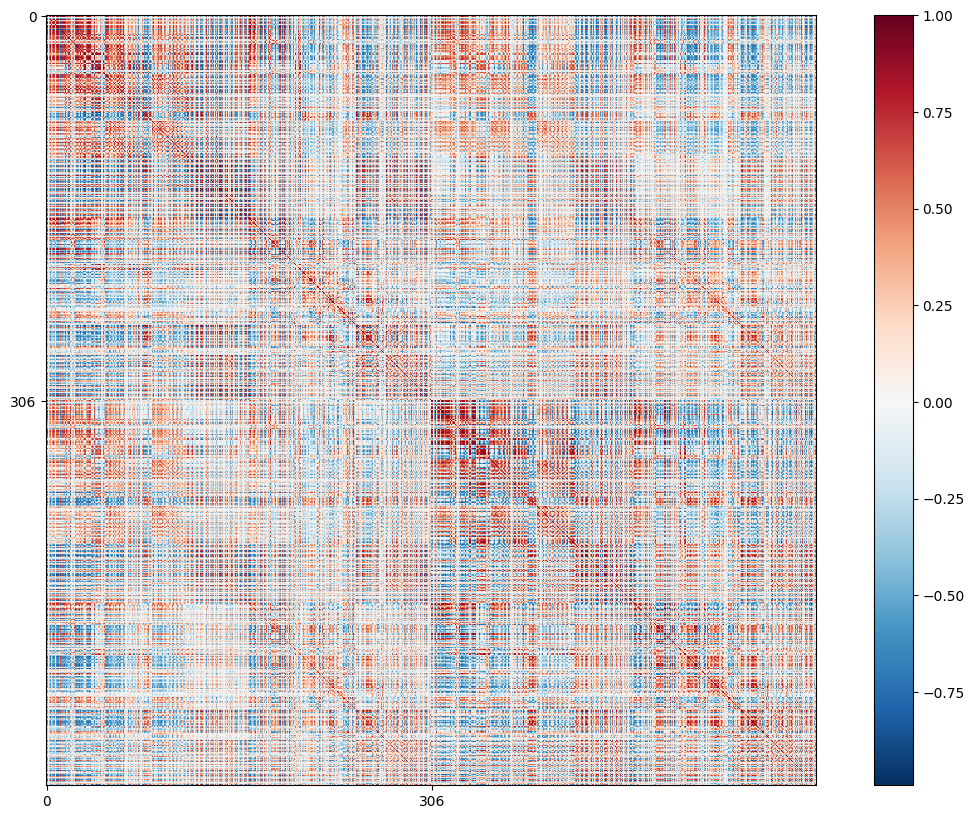

In [80]:
# mean over first dimension
data_mean = epochs_data[:, :-1, :].mean(axis=0)
gpt_mean = epochs_gpt[:, :-1, :].mean(axis=0)

# create a channel x channel correlation matrix between epochs_data_mean (timesteps, channels) and epochs_gpt_mean (timesteps, channels)
cov = np.corrcoef(data_mean.T, gpt_mean.T)

# plot the covariance matrices
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(cov, cmap='RdBu_r')

# show ticks for the covariances
ax.set_xticks(np.arange(0, 2 * 306, 306))
ax.set_yticks(np.arange(0, 2 * 306, 306))

# show scale
fig.colorbar(im, ax=ax)


In [68]:
# compute per-channel correlation between data and gpt2
corr = [np.corrcoef(data_mean[:, i], gpt_mean[:, i])[0, 1] for i in range(data_mean.shape[1])]
print(np.array(corr).mean())

0.7398747516120879
